In [1]:
import os
import numpy as np
from mypackages.edp_processing import ImageAnalysis, ImageProcessing
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## Automation for .ser files

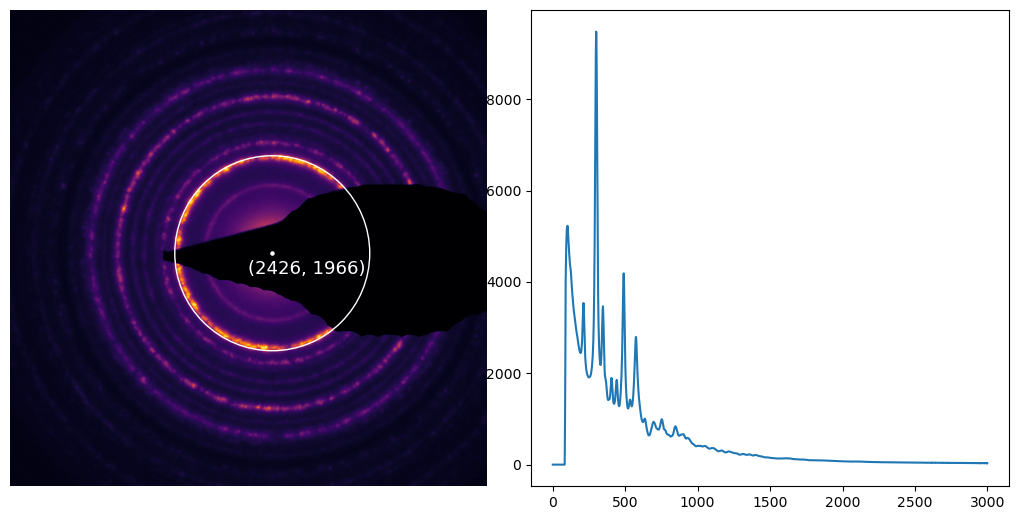

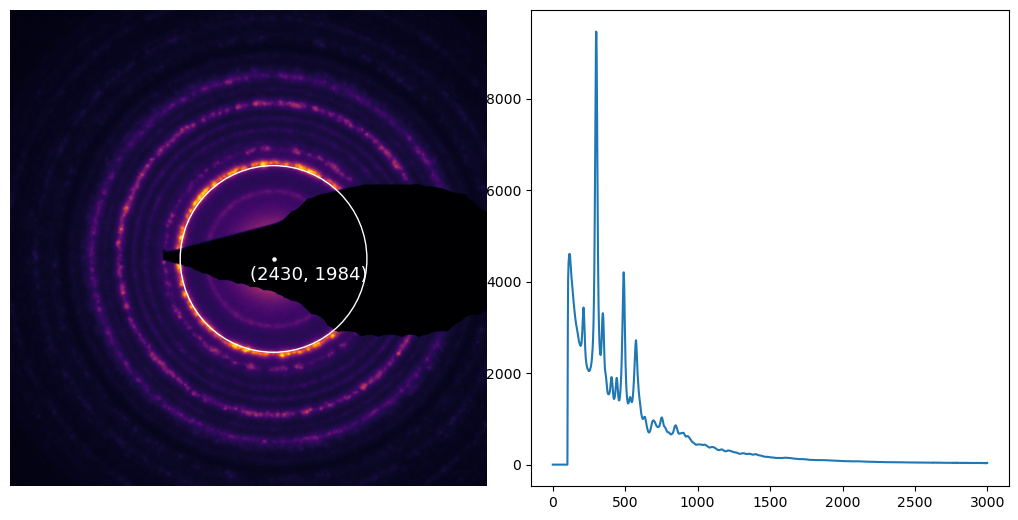

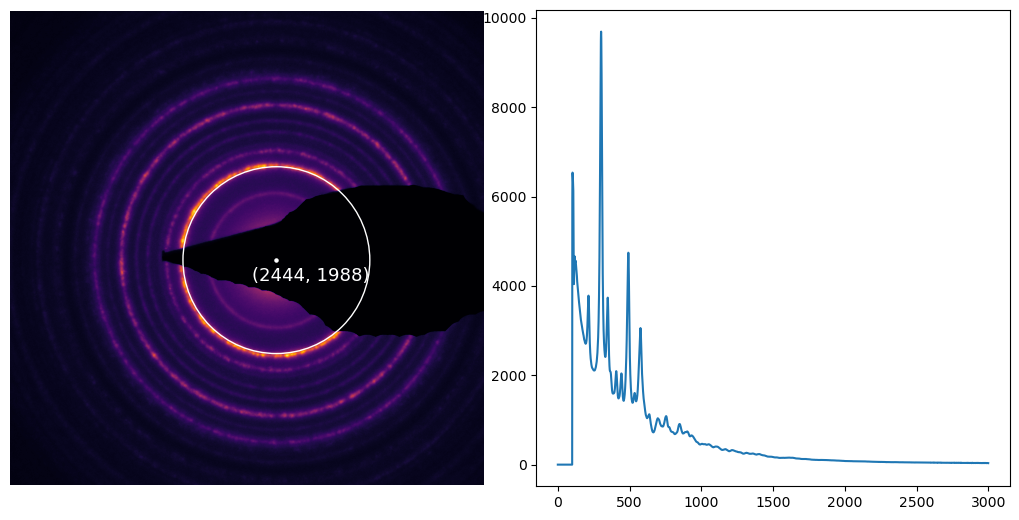

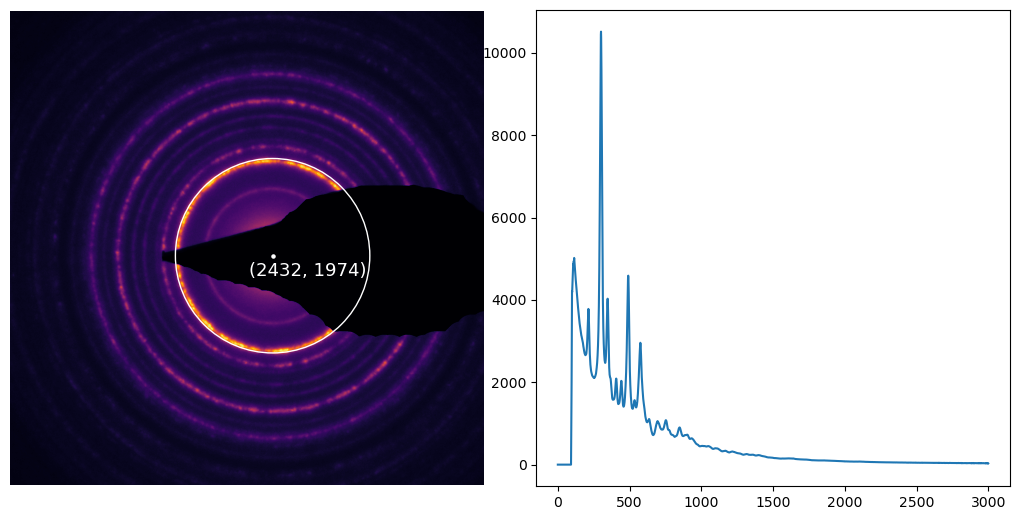

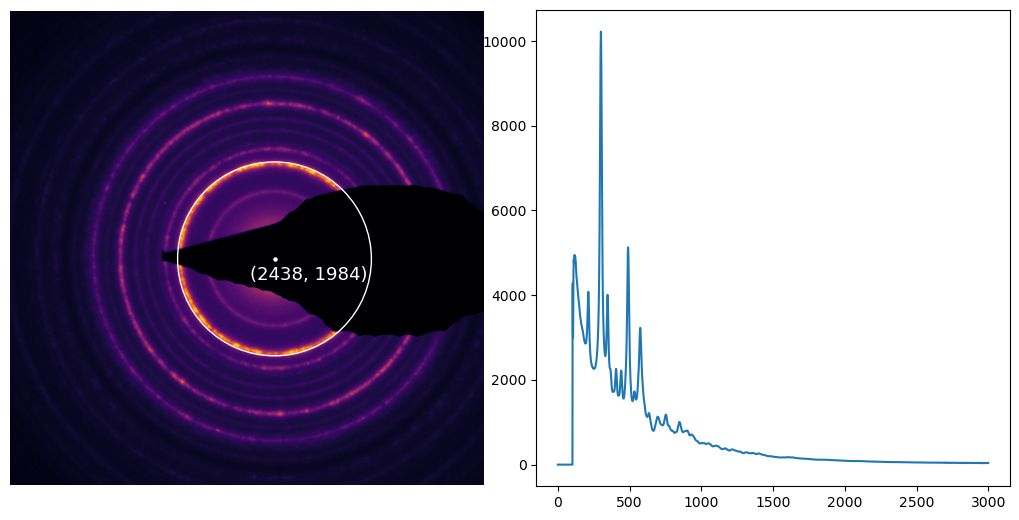

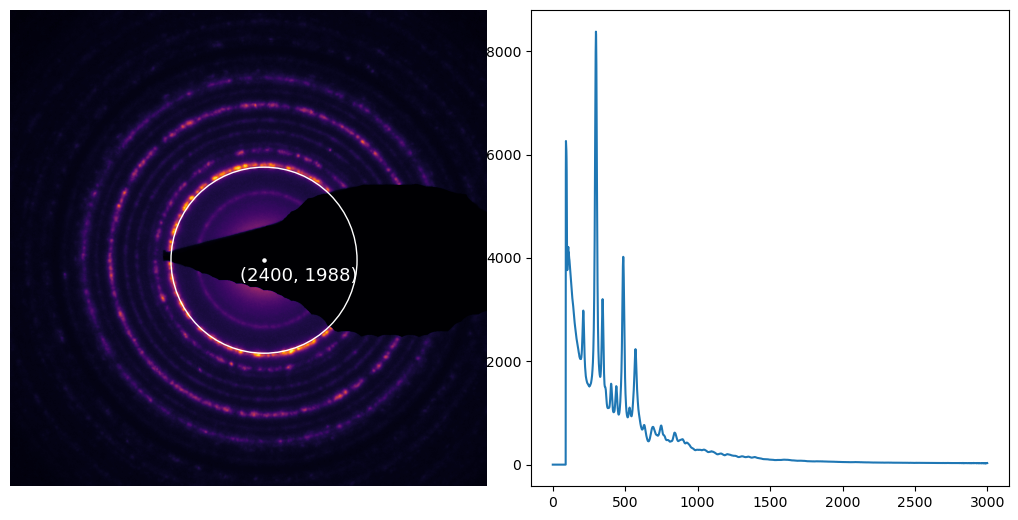

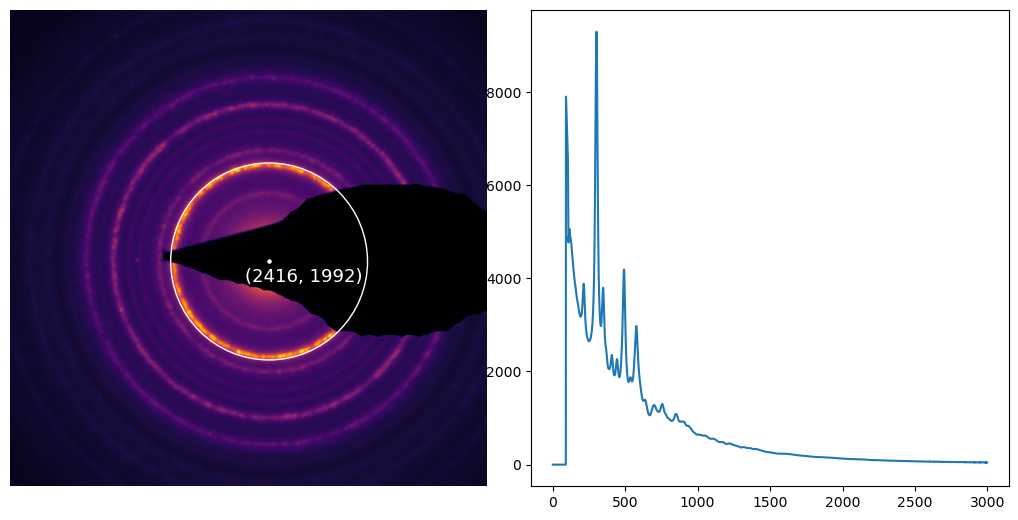

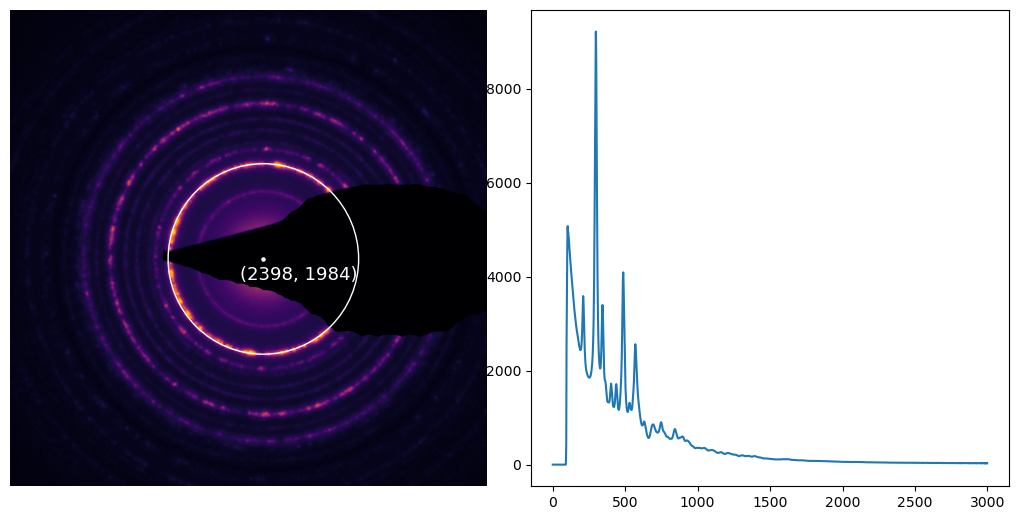

In [ ]:
directory = '/home/ABTLUS/victor.secco/data_processing/data/raw/ED/In2O3'
names = [x for x in os.listdir(directory) if x.endswith('.ser')]
names.sort()

from matplotlib.patches import Circle

# Load .ser data


# Initialize analysis and processing classes
analysis = ImageAnalysis()
processing = ImageProcessing(directory)

# Load mask once to reuse
mask_path = '/home/ABTLUS/victor.secco/data_processing/data/processed/epdf/MASKS/mask_titan.tif'
mask_beamstopper = processing.load_mask(mask_path)

#mask_defects = processing.load_mask('/home/ABTLUS/victor.secco/data_processing/ED/MASKS/test_defects_mask.png')


# Define binning
binning = 3000

# Dictionary to store centers
centers_dict = {}

# Process each diffraction pattern
for name in names:
    file_path = os.path.join(directory, name)
    import hyperspy.api as hs 
    data = hs.load(file_path, signal_type='diffraction', lazy=True)
    img = np.array(data)[1]  # Extract the second image

    # Free memory
    del data

    # Find diffraction pattern center
    center_x, center_y, r = analysis.find_center(img, r=1, R=5000, threshold=120, edges_thresh1=255, edges_thresh2=10)
    centers_dict[name] = (center_x, center_y)  # Store in dictionary

    circle1 = Circle((center_x, center_y), r, fill=False, color='white')

    # Mask beamstopper
    img[mask_beamstopper == 255] = -100
    #img[mask_defects == 255] = -100
    
    # Perform azimuthal integration
    data_1d, polar_image, _ = analysis.azimuth_integration_cv2(img, center=[center_x, center_y], binning=binning)

    # Plot results
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, cmap='inferno')
    ax[0].scatter(center_x, center_y, s=5, color='white')
    ax[0].add_patch(circle1)
    ax[0].axis('off')
    ax[0].text(center_x + 110, center_y + 50, f'{center_x, center_y}', color='white', fontsize=13, ha='center', va='center')
    
    zoom_start, zoom_end = 1600, 3100
    ax[0].set_xlim(zoom_start, zoom_end)
    ax[0].set_ylim(2700, 1200)  # y-limits reversed for images
    ax[1].plot(data_1d)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout(pad=0)
    plt.show()

# Now you can access the centers as:
# centers_dict['your_filename.ser'] -> (center_x, center_y)


In [4]:
total_images = len(names)*20
azimuthal_averages = []
binning = 3000

analysis = ImageAnalysis()
processing = ImageProcessing(directory)

mask = processing.load_mask('/home/ABTLUS/victor.secco/data_processing/data/processed/epdf/MASKS/mask_titan.tif')
#mask_defects = processing.load_mask('/home/ABTLUS/victor.secco/data_processing/data/processed/epdf/MASKS/test_defects_mask.png')


with tqdm(total=total_images, desc="Processing images", unit="image") as pbar:
    for file_path in names:
        data = hs.load(os.path.join(directory, file_path), signal_type='diffraction', lazy=True)
        imgs = np.array(data)

        for img in imgs:
            center_x, center_y, r = analysis.find_center(
                img, r=1, R=5000, threshold=120, edges_thresh1=255, edges_thresh2=10
            )

            # Load and apply mask
            
            img[mask == 255] = -100
            #img[mask_defects == 255] = -100
            img[:,0:20] = -100

            # Perform azimuthal averaging
            average, polar_image, _ = analysis.azimuth_integration_cv2(img, center=[center_x, center_y], binning=binning)
            azimuthal_averages.append(average)
            pbar.update(1)

# Convert the list of azimuthal averages into a DataFrame
azimuthal_df = pd.DataFrame(azimuthal_averages)


Processing images: 100%|██████████| 160/160 [06:14<00:00,  2.34s/image]


([], [])

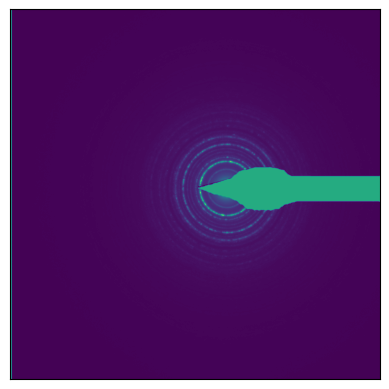

In [5]:
img[mask == 255] = 10000
#img[mask_defects == 255] = 10000
img[:,0:20] = 10000


plt.imshow(img)
plt.xticks([])
plt.yticks([])
#plt.savefig("/home/ABTLUS/victor.secco/data_processing/results/images/mask2.png", dpi = 300)

In [9]:
output_directory = "/home/ABTLUS/victor.secco/data_processing/data/processed/epdf/In2O3"

transposed_df = azimuthal_df.T
transposed_df.to_csv(os.path.join(output_directory, 'iq_In2O3_S4.csv'), index=False)

## Automation for .tif files

In [37]:
masking = False
side = False
b = 2
offset = 0

if b==4:
    binning=1024
else:
    binning=1464

# Load .tif data
directory = r"Z:\ActualWork\Victor\Au\wob\rolling_shutter"
names = [x for x in os.listdir(directory) if x.endswith('.tif')]
names.sort()

analysis = ImageAnalysis()



def pad_image_for_hough(image, pad_width=512, mode='constant'):
    padded_image = np.pad(image, ((pad_width, pad_width), (pad_width, pad_width)), mode=mode)
    return padded_image, pad_width

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.gridspec as gridspec
import math

# --- Collect data ---
results = []
centers_dict = {}

for name in names:  # or names[:N] if you want to limit
    processing = ImageProcessing(os.path.join(directory, name))
    img = processing.load_images(1)
    if side:
        img, offset = pad_image_for_hough(img, pad_width=512)

    if masking:
        beamstop_mask = processing.load_mask(r"E:\data_processing\data\processed\epdf\MASKS\spirit_mask.tif")
        if b == 1 or beamstop_mask.shape[0]==2048:
            img[beamstop_mask == 255] = 0
        elif beamstop_mask.shape[0]==4096:
            def bin_2d_by_2(arr):
                shape = arr.shape
                assert shape[0] % 2 == 0 and shape[1] % 2 == 0

                return arr.reshape(shape[0]//2, 2, shape[1]//2, 2).mean(axis=(1, 3))

            binned_mask = bin_2d_by_2(beamstop_mask)
            img[binned_mask == 255] = 0

        # defects_mask = processing.load_mask('/home/ABTLUS/victor.secco/data_processing/ED/MASKS/test_defects_mask.png')
        # img[defects_mask == 255] = 0
        
    center_x, center_y, r, thre, blur, edges = analysis.find_center(
        img, r=1, R=5000, threshold=150, edges_thresh1=255, edges_thresh2=10)
    center_x -= offset
    center_y -= offset
    centers_dict[name] = (center_x, center_y)

    data, polar_image, _ = analysis.azimuth_integration_cv2(img, center=[center_x, center_y], binning=binning)
    results.append((img, center_x, center_y, r, data, name))

images_per_row = 2
num_images = len(results)
num_rows = math.ceil(num_images / images_per_row)

fig = plt.figure(figsize=(18, 3.5 * num_rows))
gs = gridspec.GridSpec(num_rows, images_per_row * 2, figure=fig, wspace=0.4, hspace=0.4)

for i, (img, center_x, center_y, r, data, name) in enumerate(results):
    row = i // images_per_row
    col = (i % images_per_row) * 2

    # Diffraction image
    ax_img = fig.add_subplot(gs[row, col])
    ax_img.imshow(img, cmap='inferno', aspect='auto')
    ax_img.add_patch(Circle((center_x, center_y), r, fill=False, color='white', linewidth=0.8))
    ax_img.scatter(center_x, center_y, s=3, color='white')
    ax_img.axis('off')
    ax_img.set_title(name, fontsize=8)

    # Radial plot
    ax_plot = fig.add_subplot(gs[row, col + 1])
    ax_plot.plot(data, linewidth=0.8)
    ax_plot.tick_params(axis='both', labelsize=6)
    ax_plot.set_xlabel('r (px)', fontsize=7)
    ax_plot.set_ylabel('I', fontsize=7)


plt.show()


KeyboardInterrupt: 

In [38]:
from matplotlib.patches import Circle
import numpy as np
import os
import matplotlib.pyplot as plt


# Initialize classes
analysis = ImageAnalysis()
processing = ImageProcessing(directory)

# Helper to pad image for Hough center detection
def pad_image_for_hough(image, pad_width=512, mode='constant'):
    return np.pad(image, ((pad_width, pad_width), (pad_width, pad_width)), mode=mode), pad_width

# First pass: detect centers
centers = []
for name in names:
    img = ImageProcessing(os.path.join(directory, name)).load_images(1)
    if side:
        padded_img, offset = pad_image_for_hough(img, pad_width=512)
    
    cx, cy, *_ = analysis.find_center(img, r=1, R=5000, threshold=150, edges_thresh1=255, edges_thresh2=10)
    centers.append((cx - offset, cy - offset))

average_center = np.mean(centers, axis=0)
print(f"Average center: {average_center}")

if b==4:
    binning=1024
else:
    binning=1460

results = []
for name in names:
    img = ImageProcessing(os.path.join(directory, name)).load_images(1)
    if masking:
        beamstop_mask = processing.load_mask(r"E:\data_processing\data\processed\epdf\MASKS\spirit_mask.tif")
        if b == 1 or beamstop_mask.shape[0]==2048:
            img[beamstop_mask == 255] = 0
        elif beamstop_mask.shape[0]==4096:
            def bin_2d_by_2(arr):
                shape = arr.shape
                assert shape[0] % 2 == 0 and shape[1] % 2 == 0

                return arr.reshape(shape[0]//2, 2, shape[1]//2, 2).mean(axis=(1, 3))

            binned_mask = bin_2d_by_2(beamstop_mask)
            img[binned_mask == 255] = 0
    data, polar_image, _ = analysis.azimuth_integration_cv2(img, center=average_center, binning=binning)
    results.append((img, average_center[0], average_center[1], data, name))


Average center: [1017.4 1003. ]


             1             2             3             4             5   \
0  55632.000000  55623.000000  55636.000000  55632.000000  55659.000000   
1  47238.386024  47261.280548  47246.004394  47289.166230  47261.001569   
2  49662.799473  49682.235130  49675.624687  49684.968376  49677.886348   
3  51671.844267  51676.178646  51680.910571  51678.761445  51682.840387   
4  52145.202372  52151.263599  52148.901780  52154.886828  52153.090802   

             6             7             8             9             10  \
0  55673.000000  55657.000000  55678.000000  55630.000000  55703.000000   
1  47295.371535  47253.283372  47324.088136  47241.358642  47310.274531   
2  49689.422285  49671.501835  49698.899128  49673.651678  49692.357371   
3  51681.601147  51681.916453  51677.590315  51684.334319  51677.157163   
4  52150.952870  52155.535150  52145.726103  52158.537513  52145.519539   

             11            12            13            14            15  \
0  55708.000000  55712.

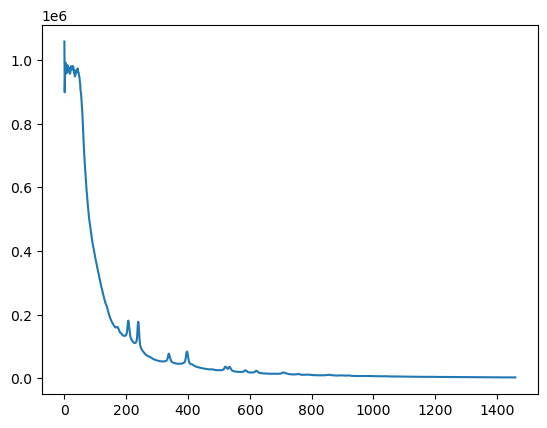

In [39]:
df_data = pd.DataFrame([data for _, _, _, data, _ in results]).T
df_data.drop(columns=[0], inplace=True)
# Preview
print(df_data.head())

iq = df_data.sum(axis=1)

output_directory = r"C:\Users\seccolev\data_processing\data\processed\ePDF\Au\20250716"

pd.DataFrame(df_data).to_csv(os.path.join(output_directory, "Au_roll.csv"), index=None)

plt.plot(iq)


(500.0, 15000.0)

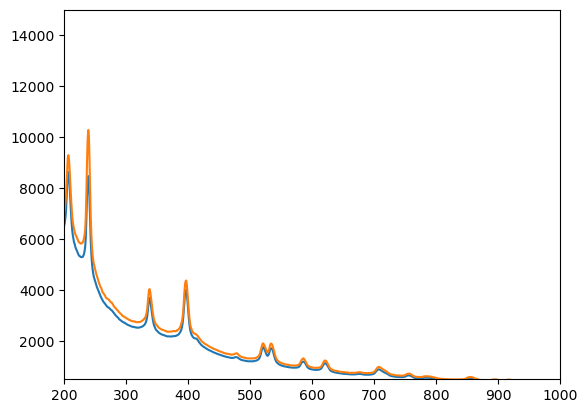

In [40]:
plt.plot(iq/21)
plt.plot(df_data[1].values)
plt.xlim(200, 1000)
plt.ylim(500, 15000)

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from collections import defaultdict

masking = False
side = False
b = 2
offset = 0

base_directory = r"Z:\ActualWork\Victor\F-Mno-acac-S2\20250708"

analysis = ImageAnalysis()
processing = ImageProcessing(base_directory)

def pad_image_for_hough(image, pad_width=512, mode='constant'):
    return np.pad(image, ((pad_width, pad_width), (pad_width, pad_width)), mode=mode), pad_width

folder_images = defaultdict(list)
for root, dirs, files in os.walk(base_directory):
    for file in sorted(files):
        if file.lower().endswith('.tif'):
            full_path = os.path.join(root, file)
            folder_images[root].append(full_path)

results = []
for folder, image_paths in folder_images.items():
    print(f"Processing folder: {folder}")

    centers = []
    for full_path in image_paths:
        img = ImageProcessing(full_path).load_images(1)
        if side:
            img, offset = pad_image_for_hough(img)
        cx, cy, *_ = analysis.find_center(img, r=1, R=5000, threshold=200, edges_thresh1=255, edges_thresh2=10)
        centers.append((cx - offset, cy - offset))

    folder_center = np.mean(centers, axis=0)
    print(f"Center for folder '{folder}': {folder_center}")

    for full_path in image_paths:
        img = ImageProcessing(full_path).load_images(1)

        if masking:
            beamstop_mask = processing.load_mask(r"E:\data_processing\data\processed\epdf\MASKS\spirit_mask.tif")
            if b == 1 or beamstop_mask.shape[0] == 2048:
                img[beamstop_mask == 255] = 0
            elif beamstop_mask.shape[0] == 4096:
                def bin_2d_by_2(arr):
                    shape = arr.shape
                    assert shape[0] % 2 == 0 and shape[1] % 2 == 0
                    return arr.reshape(shape[0]//2, 2, shape[1]//2, 2).mean(axis=(1, 3))

                binned_mask = bin_2d_by_2(beamstop_mask)
                img[binned_mask == 255] = 0

        binning = 1024 if b == 4 else 1460
        data, polar_image, _ = analysis.azimuth_integration_cv2(img, center=folder_center, binning=binning)
        results.append(data)

# Convert to DataFrame
azimuthal_df = pd.DataFrame(results)


Processing folder: Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi1
Center for folder 'Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi1': [1037.  1014.3]
Processing folder: Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi2
Center for folder 'Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi2': [1040.9 1010.5]
Processing folder: Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi3
Center for folder 'Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi3': [1030.   994.7]
Processing folder: Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi4
Center for folder 'Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi4': [1054.4 1021.4]
Processing folder: Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi5
Center for folder 'Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi5': [1042.  1013.2]
Processing folder: Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi6
Center for folder 'Z:\ActualWork\Victor\F-Mno-acac-S2\20250708\roi6': [1033.4 1017.9]


In [29]:
azimuthal_df

,0,1,2,3,4,5,6,7,8,9,...,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
0,53491.0,53440.177554,53782.745938,53839.390314,53898.675781,53969.442205,53974.737597,53919.214513,53883.657742,53897.333550,...,1043.636166,1026.744231,1027.648481,1021.213708,1012.817101,1029.159356,1020.745716,1035.956820,1017.089445,1077.5
1,53663.0,53508.171170,53800.999722,53848.888270,53907.349854,53970.795322,53985.899249,53925.726477,53891.700417,53901.418603,...,1023.542381,1025.143706,1021.917706,1021.806854,1035.017032,1062.717443,1024.169637,1014.586246,1012.896162,1021.0
2,53470.0,53427.407049,53772.066910,53847.365145,53905.231195,53961.773361,53977.132690,53916.850252,53880.967487,53893.053553,...,1022.194768,1031.339159,1043.174412,1027.316929,1017.426114,1008.868403,993.668095,1025.135024,1010.328650,1042.5
3,53638.0,53504.100321,53795.650240,53857.712434,53910.023011,53965.718056,53982.005490,53924.036307,53888.200061,53899.441996,...,1018.582134,1012.962646,1015.049212,1019.278684,1021.880432,1039.767135,1026.377142,1004.636509,1002.895819,1064.0
4,53538.0,53438.628071,53770.585168,53845.659398,53900.262744,53967.166828,53972.226693,53920.392283,53883.662844,53895.632974,...,1004.734521,1010.149532,1036.169020,1061.440576,1030.515696,1034.583962,1034.148218,1042.397989,1044.955106,1031.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,53799.0,54047.939094,53959.015675,53959.869834,53896.303681,53879.401546,53806.607251,53836.648427,53976.478385,53991.426775,...,1103.491432,1108.133653,1137.365661,1124.511081,1105.000000,1140.370802,1134.599040,873.738177,0.000000,0.0
116,53806.0,54026.291747,53947.601735,53943.927373,53884.704132,53866.946240,53801.747279,53832.529695,53968.677130,53986.212676,...,1150.814599,1117.900788,1140.913982,1128.476811,1119.000000,1119.288897,1099.548321,865.677862,0.000000,0.0
117,53804.0,54051.147223,53959.158652,53966.394960,53893.691171,53882.479446,53813.632968,53843.062222,53982.395648,53997.167648,...,1111.597841,1098.534441,1126.416381,1122.946196,1126.500000,1063.931117,1138.940027,995.448938,0.000000,0.0
118,53796.0,54045.219301,53959.597994,53964.713833,53892.867507,53878.066563,53806.997895,53834.016192,53971.634912,53990.253660,...,1103.318540,1090.426833,1138.384167,1136.090473,1134.000000,1112.633996,1120.652844,877.768334,0.000000,0.0


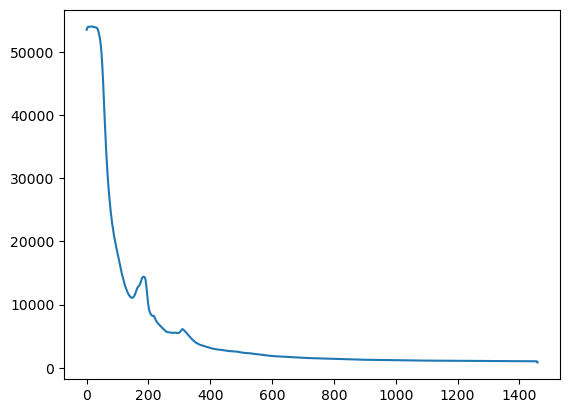

In [30]:
iq = azimuthal_df.T.mean(axis=1)

output_directory = r"C:\Users\seccolev\data_processing\data\processed\ePDF\MnO"

pd.DataFrame(azimuthal_df.T).to_csv(os.path.join(output_directory, "iq_all_profiles_mno.csv"), index=None)

plt.plot(iq)

In [ ]:
output_directory = "/home/ABTLUS/victor.secco/data_processing/data/processed/epdf/In2O3"

transposed_df = azimuthal_df.T
transposed_df.to_csv(os.path.join(output_directory, 'iq_In2O3_S4.csv'), index=False)